In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import glob
import platform
import pathlib  
import os.path
#!pip install netCDF4 h5netcdf
import datetime
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from matplotlib.animation import FuncAnimation


In [2]:
cwd = pathlib.Path().resolve()
src = cwd.parent
data = src.parent.parent.parent
OS_type = platform.system()

if OS_type == 'Darwin':
    username = 'Mats '
    data_path = os.path.join(data, 'data_tana', 'Sattelite')
else:
    username = 'Mootje'
    data_path = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data', 'Satellite')

print(f"Welcome {username}, have a wondeful day on your {OS_type} machine. Your data should be located in {data_path}")

Welcome Mootje, have a wondeful day on your Windows machine. Your data should be located in C:\Users\Moniek van Zon\OneDrive - Delft University of Technology\TU Delft\Master ENVM\MDP\Model\Data\Satellite


In [3]:
data_files = glob.glob(os.path.join(data_path, '*.nc'))

datasets = {}

for file_path in data_files:
    # Extract the file identifier from the file name
    file_name = os.path.basename(file_path)  # Get just the file name
    file_identifier = file_name.split('_')[0]  # Split by underscore and take the first part
    # print(file_identifier)
    # Open the dataset
    dataset = xr.open_dataset(file_path)
    # print(dataset)
    # Add the file identifier as a new coordinate
    dataset = dataset.assign_coords(file_identifier=file_identifier)
    
    # Add the dataset to the dictionary with the file identifier as the key
    datasets[file_identifier] = dataset
    # print(datasets[file_identifier])
chirps_file = data_files[0]

In [4]:
chirps = datasets['chirps']
chirps

<xarray.Dataset> Size: 463MB
Dimensions:          (latitude: 210, longitude: 302, time: 1826)
Coordinates:
  * latitude         (latitude) float32 840B -5.025 -4.975 ... 5.375 5.425
  * longitude        (longitude) float32 1kB 28.47 28.52 28.57 ... 43.47 43.52
  * time             (time) datetime64[ns] 15kB 2018-01-01 ... 2022-12-31
    file_identifier  <U6 24B 'chirps'
Data variables:
    precip           (time, latitude, longitude) float32 463MB ...
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2019-01-30
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day....
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

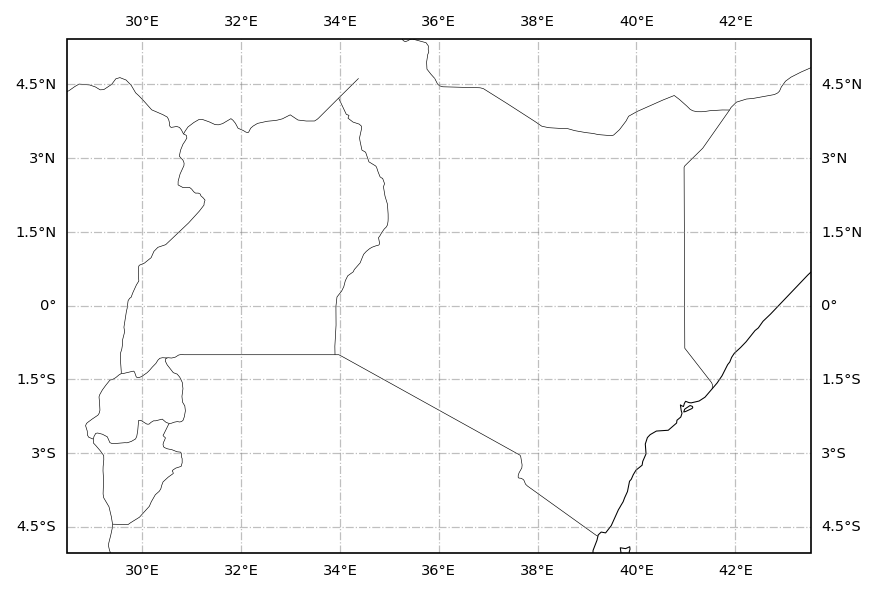

In [5]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# First we specify Coordinate Refference System for Map Projection
# We will use Mercator, which is a cylindrical, conformal projection. 
# It has bery large distortion at high latitudes, cannot 
# fully reach the polar regions.
projection = ccrs.Mercator()

# Specify CRS, that will be used to tell the code, where should our data be plotted
crs = ccrs.PlateCarree()

# Now we will create axes object having specific projection 
plt.figure(dpi=150)
ax = plt.axes(projection=projection, frameon=True)

# Draw gridlines in degrees over Mercator map
gl = ax.gridlines(crs=crs, draw_labels=True,
                  linewidth=.6, color='gray', alpha=0.5, linestyle='-.')
gl.xlabel_style = {"size" : 7}
gl.ylabel_style = {"size" : 7}

# To plot borders and coastlines, we can use cartopy feature
import cartopy.feature as cf
ax.add_feature(cf.COASTLINE.with_scale("50m"), lw=0.5)
ax.add_feature(cf.BORDERS.with_scale("50m"), lw=0.3)

# Now, we will specify extent of our map in minimum/maximum longitude/latitude
# Note that these values are specified in degrees of longitude and degrees of latitude
# However, we can specify them in any crs that we want, but we need to provide appropriate
# crs argument in ax.set_extent
lon_min = chirps["longitude"][0]
lon_max = chirps['longitude'][-1]
lat_min = chirps['latitude'][0]
lat_max = chirps['latitude'][-1]

# crs is PlateCarree -> we are explicitly telling axes, that we are creating bounds that are in degrees
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)
# chirps["precip"].plot.contourf(ax=ax, transform=ccrs.PlateCarree())
# plt.title(f"Temperature anomaly over Europe in {original_data.valid_time.dt.strftime('%B %Y').values}")
plt.show()


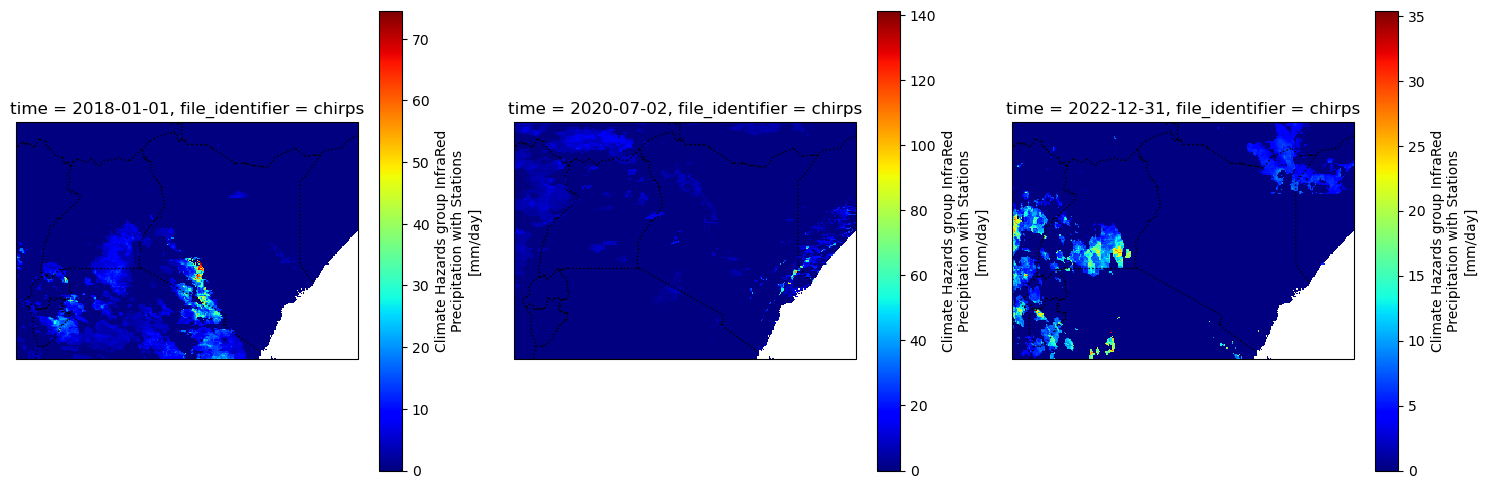

In [6]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# Select the precipitation variable
precipitation = chirps['precip']

# Create a figure and axis with a PlateCarree projection
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# Loop over three time steps (you can adjust this based on your preference)
for i, time_index in enumerate([0, len(precipitation.time) // 2, len(precipitation.time) - 1]):
    ax = axes[i]
    ax.set_title(f'Precipitation at time step {time_index}')
    
    # Plot precipitation data
    precipitation.isel(time=time_index).plot(ax=ax, cmap='jet', transform=ccrs.PlateCarree())
    
    lon_min = chirps["longitude"][0]
    lon_max = chirps['longitude'][-1]
    lat_min = chirps['latitude'][0]
    lat_max = chirps['latitude'][-1]

    # crs is PlateCarree -> we are explicitly telling axes, that we are creating bounds that are in degrees
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)

    # # Add coastlines and gridlines
    # ax.coastlines()
    # ax.gridlines(draw_labels=True)
    
    
    # Add country borders as reference
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
plt.tight_layout()
plt.show()

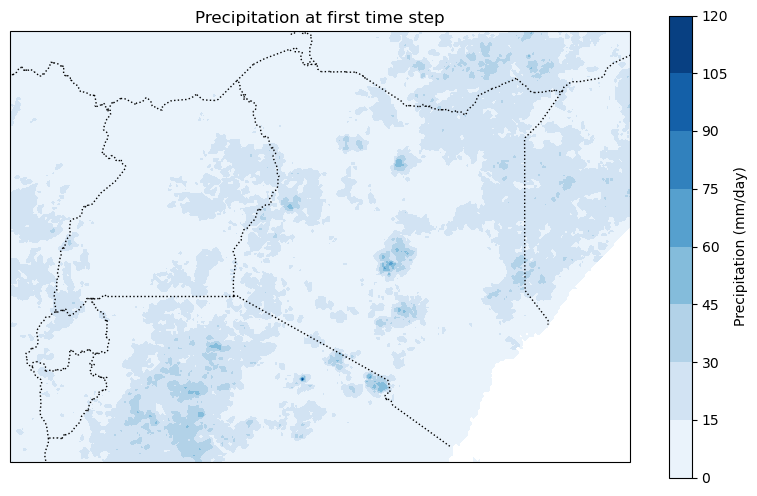

In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Select a specific time slice (e.g., the first time step)
precip_at_first_time_step = chirps['precip'][100]

# Create a map
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Plot precipitation
im = ax.contourf(precip_at_first_time_step['longitude'], 
                 precip_at_first_time_step['latitude'],
                 precip_at_first_time_step, 
                 transform=ccrs.PlateCarree(), 
                 cmap='Blues')

# Add coastlines and gridlines
# ax.coastlines()
# ax.gridlines(draw_labels=True)

lon_min = chirps["longitude"][0]
lon_max = chirps['longitude'][-1]
lat_min = chirps['latitude'][0]
lat_max = chirps['latitude'][-1]

# crs is PlateCarree -> we are explicitly telling axes, that we are creating bounds that are in degrees
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Precipitation (mm/day)')

# Show the plot
plt.title('Precipitation at first time step')
plt.show()


In [8]:
time_values = chirps.variables['time'][:]
time_values


<xarray.IndexVariable 'time' (time: 1826)> Size: 15kB
array(['2018-01-01T00:00:00.000000000', '2018-01-02T00:00:00.000000000',
       '2018-01-03T00:00:00.000000000', ..., '2022-12-29T00:00:00.000000000',
       '2022-12-30T00:00:00.000000000', '2022-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Attributes:
    standard_name:  time
    axis:           T

In [9]:
# loading station data from TAHMO

# location_file = glob.glob(os.path.join(data_path, 'location_data_tahmoTA00023.csv'))
data_path_location = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data', 'TAHMO','location_data_tahmoTA00023.csv')
data_path_location
# data_files_location = glob.glob(os.path.join(data_path, 'location_data_tahmoTA00023.csv'))
df_loc = pd.read_csv(data_path_location, index_col = 0, sep =',', parse_dates = True)
long = df_loc['longitude'].iloc[0]
lat = df_loc['lattitude'].iloc[0]

chirps_file = chirps
station_file = df_loc

[datetime.datetime(2018, 1, 1, 0, 0), datetime.datetime(2018, 1, 2, 0, 0), datetime.datetime(2018, 1, 3, 0, 0), datetime.datetime(2018, 1, 4, 0, 0), datetime.datetime(2018, 1, 5, 0, 0), datetime.datetime(2018, 1, 6, 0, 0), datetime.datetime(2018, 1, 7, 0, 0), datetime.datetime(2018, 1, 8, 0, 0), datetime.datetime(2018, 1, 9, 0, 0), datetime.datetime(2018, 1, 10, 0, 0), datetime.datetime(2018, 1, 11, 0, 0), datetime.datetime(2018, 1, 12, 0, 0), datetime.datetime(2018, 1, 13, 0, 0), datetime.datetime(2018, 1, 14, 0, 0), datetime.datetime(2018, 1, 15, 0, 0), datetime.datetime(2018, 1, 16, 0, 0), datetime.datetime(2018, 1, 17, 0, 0), datetime.datetime(2018, 1, 18, 0, 0), datetime.datetime(2018, 1, 19, 0, 0), datetime.datetime(2018, 1, 20, 0, 0), datetime.datetime(2018, 1, 21, 0, 0), datetime.datetime(2018, 1, 22, 0, 0), datetime.datetime(2018, 1, 23, 0, 0), datetime.datetime(2018, 1, 24, 0, 0), datetime.datetime(2018, 1, 25, 0, 0), datetime.datetime(2018, 1, 26, 0, 0), datetime.datetime(20

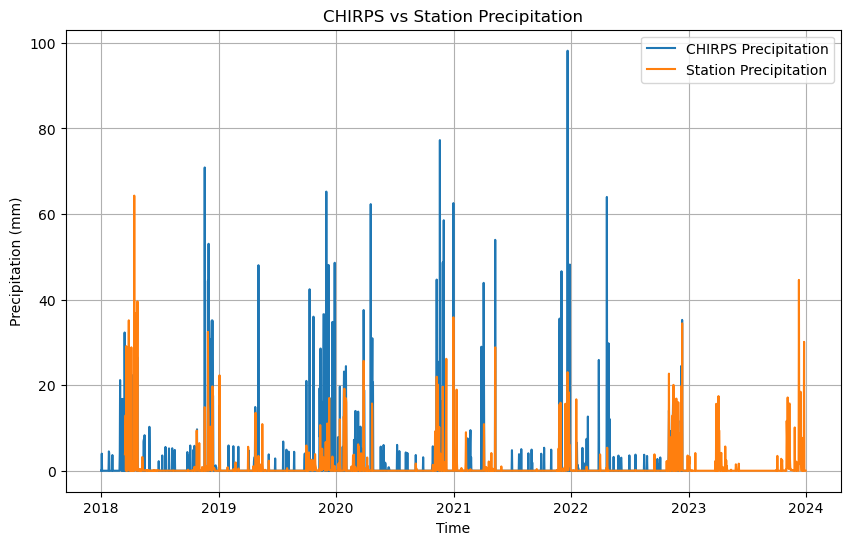

Correlation Coefficient: 0.43710460374020116
Root Mean Square Error (RMSE): 7.0216401651164775


In [10]:
import numpy as np
import pandas as pd
import netCDF4 as nc
import matplotlib.pyplot as plt
import tempfile

def extract_chirps_data(chirps_file, lat, lon):
    with nc.Dataset(chirps_file, 'r') as dataset:
        lat_values = dataset.variables['latitude'][:]
        lon_values = dataset.variables['longitude'][:]
        time_values = dataset.variables['time'][:]
        precipitation_values = dataset.variables['precip'][:]

        lat_index = np.abs(lat_values - lat).argmin()
        lon_index = np.abs(lon_values - lon).argmin()

        chirps_precip = precipitation_values[:, lat_index, lon_index]

        # Convert numerical time steps to datetime objects
        units = dataset.variables['time'].units
        start_date = datetime.datetime.strptime(units, "days since %Y-%m-%d")
        chirps_time = [start_date + datetime.timedelta(days=int(time_step)) for time_step in time_values]

    return chirps_time, chirps_precip

# Function to extract station data for a specific location
def extract_station_data(station_file):
    station_data = pd.read_csv(station_file)
    return station_data

# Function to calculate correlation coefficient and RMSE
def calculate_metrics(chirps_time, chirps_precip, station_time, station_precip):
    # Convert datetime objects to timestamps
    chirps_timestamps = [time.timestamp() for time in chirps_time]
    station_timestamps = [time.timestamp() for time in station_time]
    
    # Interpolate station data to match CHIRPS time points
    interpolated_station_precip = np.interp(chirps_timestamps, station_timestamps, station_precip)
    
    # Calculate correlation coefficient and RMSE
    correlation = np.corrcoef(chirps_precip, interpolated_station_precip)[0, 1]
    rmse = np.sqrt(np.mean((chirps_precip - interpolated_station_precip)**2))
    
    return correlation, rmse


# Main function
def main():
    # Specify the location (latitude and longitude) for verification
    target_lat = lat
    target_lon = long
    # File paths for CHIRPS and station data
    chirps_file = chirps
    station_file = df_loc

    # Save chirps_file to a temporary NetCDF file
    with tempfile.NamedTemporaryFile(suffix='.nc', delete=False) as temp_chirps_file:
        chirps.to_netcdf(temp_chirps_file.name)
        temp_chirps_file_path = temp_chirps_file.name

    # Extract data for the specified location
    chirps_time, chirps_precip = extract_chirps_data(temp_chirps_file_path, target_lat, target_lon)
    print(chirps_time)
    station_data = extract_station_data(data_path_location)
    # station_data
    station_time = pd.to_datetime(station_data['Timestamp'])
    station_precip = station_data['pr']

    # Calculate correlation coefficient and RMSE
    correlation, rmse = calculate_metrics(chirps_time, chirps_precip, station_time, station_precip)

    # Plot CHIRPS and station precipitation
    plt.figure(figsize=(10, 6))
    plt.plot(chirps_time, chirps_precip, label='CHIRPS Precipitation')
    plt.plot(station_time, station_precip, label='Station Precipitation')
    plt.xlabel('Time')
    plt.ylabel('Precipitation (mm)')
    plt.title('CHIRPS vs Station Precipitation')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print verification metrics
    print(f'Correlation Coefficient: {correlation}')
    print(f'Root Mean Square Error (RMSE): {rmse}')

if __name__ == "__main__":
    main()


In [11]:
from shapely.geometry import Point

# plot the catchment area
shape_path = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data', 'Shapefiles')
shape_file = os.path.join(shape_path, '*.gpkg')
shape_files = glob.glob(shape_file)
gdfs = []

for file in shape_files:
    gdf = gpd.read_file(file)
    gdfs.append(gdf)

merged_gdfs = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
# merged_gdfs.plot(color = 'bisque', edgecolor = 'black')

In [20]:
chirps_file['time']
start_date = '2023-10-01'
end_date = '2023-12-31'

chirps_OND_23 = chirps.sel(time = slice(start_date, end_date))


['C:\\Users\\Moniek van Zon\\OneDrive - Delft University of Technology\\TU Delft\\Master ENVM\\MDP\\Model\\Data\\Satellite\\chirps_2018_2022_28.45_43.55_-5.05_5.45.nc',
 'C:\\Users\\Moniek van Zon\\OneDrive - Delft University of Technology\\TU Delft\\Master ENVM\\MDP\\Model\\Data\\Satellite\\era5_2018_2022_28.45_43.55_-5.05_5.45.nc',
 'C:\\Users\\Moniek van Zon\\OneDrive - Delft University of Technology\\TU Delft\\Master ENVM\\MDP\\Model\\Data\\Satellite\\gsmap_gauge_v7_aoi_daily.nc',
 'C:\\Users\\Moniek van Zon\\OneDrive - Delft University of Technology\\TU Delft\\Master ENVM\\MDP\\Model\\Data\\Satellite\\imerg_2018_2022_late_28.45_43.55_-5.05_5.45.nc']

In [14]:
def clip_netCDF_to_geopackage(netCDF_file, geopackage_file):
    # Open the GeoPackage file
    geopackage_gdf = gpd.read_file(geopackage_file)

    # Open the NetCDF file
    with rasterio.open(netCDF_file) as src:
        # Read the NetCDF data
        data = src.read(1)

        # Clip the NetCDF data to the GeoPackage boundaries
        clipped_data, _ = mask(src, geopackage_gdf.geometry, crop=True, nodata=np.nan)

        # Get metadata for the clipped data
        meta = src.meta.copy()

    return clipped_data, meta

# Example usage:

netCDF_file = data_files[0]  # Assuming data_files contains the list of NetCDF file paths
for geopackage_file in shape_files:  # Assuming shape_files is a list of GeoPackage file paths
    clipped_data, meta = clip_netCDF_to_geopackage(netCDF_file, geopackage_file)

# clipped_data, meta = clip_netCDF_to_geopackage(chirps_file, shape_files)
clipped_data

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

7471992


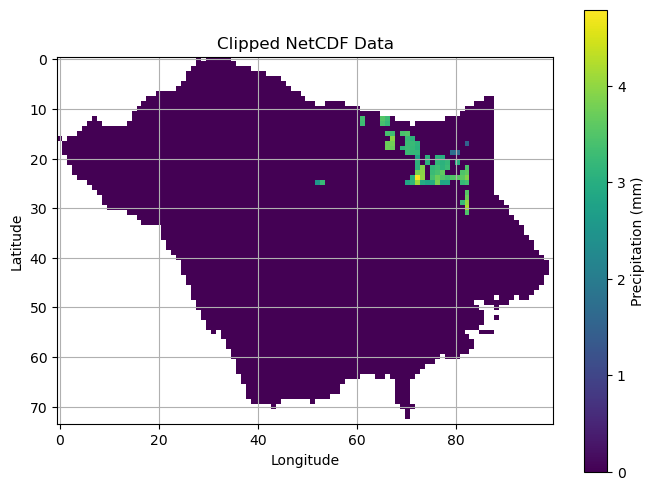

In [ ]:
clipped_values = np.count_nonzero(~np.isnan(clipped_data))
print(clipped_values)
plt.figure(figsize=(8, 6))
plt.imshow(clipped_data[0])#, extent=[lon_min, lon_max, lat_min, lat_max])
plt.colorbar(label='Precipitation (mm)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clipped NetCDF Data')
plt.grid(True)
plt.show()

In [39]:
clipped_values = clipped_data[~np.isnan(clipped_data)]
min_value = np.nanmin(clipped_values)
max_value = np.nanmax(clipped_values)
percentile_90 = np.nanpercentile(clipped_values, 99)
percentile_90

41.87806617736814

In [35]:
from matplotlib.animation import FuncAnimation
overall_min = 0
overall_max = 350

# Define a function to update the plot for each frame
def update(frame):
    plt.clf()  # Clear the current figure to update with the next frame
    plt.imshow(clipped_data[frame], vmin=overall_min, vmax=percentile_90)
    plt.colorbar(label='Precipitation (mm)', ticks=[overall_min, percentile_90])  # Add colorbar with fixed scale
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Clipped NetCDF Data (Time Step {frame})')
    # plt.grid(True)

# # Create a figure and axis for the animation
# fig, ax = plt.subplots(figsize=(8, 6))

# # Create the animation
# animation = FuncAnimation(fig, update, frames=len(clipped_data), interval=100)

# # Save the animation as a GIF
# animation.save('clipped_data_animation.gif', writer='pillow')  # Use 'imagemagick' if 'pillow' does not work

# # Show the animation (optional)
# plt.show()

In [23]:
print(shape_files)

['C:\\Users\\Moniek van Zon\\OneDrive - Delft University of Technology\\TU Delft\\Master ENVM\\MDP\\Model\\Data\\Shapefiles\\total_tana_catchement_area_clip_projected.gpkg']


In [31]:
def clip_netCDF_to_geopackage_specific_time(netCDF_file, geopackage_file, start_date, end_date):
    
    # Open the GeoPackage file
    geopackage_gdf = gpd.read_file(geopackage_file)

    # Open the NetCDF file
    ds = xr.open_dataset(netCDF_file)

    # Select data for the specified time range
    subset = ds.sel(time=slice(start_date, end_date))

    # Get the data array for the specified variable
    data_array = subset['time']

    # Clip the NetCDF data to the GeoPackage boundaries
    with rasterio.open(netCDF_file) as src:
        clipped_data, _ = mask(src, geopackage_gdf.geometry, crop=True, nodata=np.nan)

    # Get metadata for the clipped data
    meta = src.meta.copy()
    
    return clipped_data, meta

# Example usage:

netCDF_file = data_files[0]  # Replace with your NetCDF file path
geopackage_file = shape_files  # Replace with your GeoPackage file path
start_date = '2023-10-01'
end_date = '2023-12-31'

for geopackage_file in shape_files:  # Assuming shape_files is a list of GeoPackage file paths
    clipped_data, meta = clip_netCDF_to_geopackage_specific_time(netCDF_file, geopackage_file, start_date, end_date)
# Replace 'your_variable', '2022-01-01', and '2022-01-31' with the appropriate variable 
# clipped_data, meta = clip_netCDF_to_geopackage_specific_time(netCDF_file, geopackage_file, start_date, end_date)

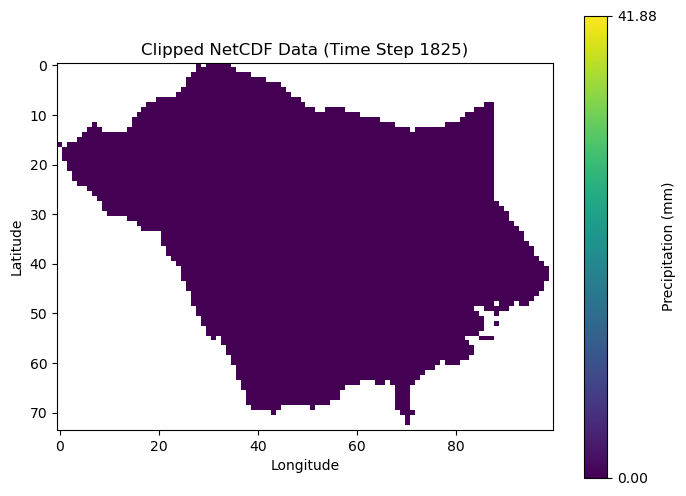

In [40]:
def update_2(frame):
    plt.clf()  # Clear the current figure to update with the next frame
    plt.imshow(clipped_data[frame], vmin=overall_min, vmax=percentile_90)
    plt.colorbar(label='Precipitation (mm)', ticks=[overall_min, percentile_90])  # Add colorbar with fixed scale
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Clipped NetCDF Data (Time Step {frame})')
    # plt.grid(True)

# Create a figure and axis for the animation
fig, ax = plt.subplots(figsize=(8, 6))

# Create the animation for selected frames
animation = FuncAnimation(fig, update, frames=len(clipped_data), interval=100)

# Save the animation as a GIF
animation.save('selected_data_animation.gif', writer='pillow')  # Use 'imagemagick' if 'pillow' does not work

# Show the animation (optional)
plt.show()

In [ ]:
from matplotlib.widgets import Slider